<a href="https://colab.research.google.com/github/honghanhh/wqu_capstone_project_3621/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>

# MScFE Capstone Project
### GROUP NUMBER: 3621



# BTC Price Prediction using Probabilistic Graphical Models for swing trading

</center>

# **1. Introduction**


The objective of this project is to develop a predictive model for Bitcoin (BTC) price using a Probabilistic Graphical Model (PGM). By leveraging the power of PGMs, we aim to identify the key sentiment, financial, technical, and on-chain factors that significantly influence the price of BTC. This analysis will provide valuable insights for swing traders looking to make informed trading decisions.

The project encompasses the following goals:

**Factor Identification**: We will carefully analyze a diverse set of sentiment, financial, technical, and on-chain metrics to identify the most influential factors affecting the price of BTC. By understanding these factors, we can gain deeper insights into the market dynamics.

**PGM Construction**: Using the identified factors, we will construct a sophisticated Probabilistic Graphical Model. This model will capture the complex relationships and dependencies among the factors, allowing us to make accurate predictions about future BTC price movements.

**Performance Comparison**:  To demonstrate the effectiveness of our approach, we will compare the performance of Markov Networks and Bayesian Networks in predicting prices. By evaluating and contrasting the results obtained from both models, our goal is to highlight the potential advantages and feasibility of each model in the context of swing trading.

By achieving these objectives, we seek to provide traders and investors with a valuable tool for making informed decisions in the dynamic and volatile world of cryptocurrency trading.

# **2. Import necessary libraries**

In [ ]:
# Install and import the required libraries
!pip install quandl
!pip install yfinance
!pip install pgmpy
!pip install "git+https://github.com/lopatovsky/HMMs.git"
!pip install pytrends
!pip install ta
!pip install coinmetrics-api-client


# Import
import ta
import os
import copy
import hmms
import quandl

import numpy as np
import pandas as pd
import yfinance as yf
import pandas_datareader as pdr
import pandas_datareader.data as web

from scipy import stats
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib.collections import LineCollection
from matplotlib.colors import Colormap, ListedColormap, BoundaryNorm
from coinmetrics.api_client import CoinMetricsClient

import pylab as plb
import networkx as nx
from tqdm import tqdm
from pytrends.request import TrendReq
from pgmpy.models import BayesianNetwork
from pgmpy.models import MarkovNetwork
from pgmpy.estimators import BDeuScore, BDsScore, BicScore, HillClimbSearch, K2Score, BayesianEstimator

import warnings
warnings.filterwarnings("ignore")

# **3. Import data**

Our dataset covers a 7 and a half year period from Jan 1, 2016, to July 1, 2023. It includes a set of variables that we believe to influence the price of Bitcoin and ETH. These variables may be adjusted and supplemented based on the initial performance of our model. Our aim is to utilize a weekly timeframe for predicting BTC/USD and ETH/USD prices.

The data collection encompasses four broad categories:

1. **Financial Data**: This includes data from the S&P, Gold, 13-Week Treasury, and the USD Index. We sourced our financial data from Yahoo Finance.

2. **On-chain Data**: This comprises variables such as hash rate, block difficulty, and transaction count. We relied on the Coin Metrics API v4 for acquiring this data.

3. **Sentiment Data**: This relies on Google Trends data, specifically focusing on the word count associated with Bitcoin and ETH to gauge sentiment. We used the Google Trends Python API for this data collection.

4. **Bitcoin Market Data**: This category includes Bitcoin and Ethereum price and volume data.

By utilizing this robust data collection methodology, we aim to build a comprehensive model for Bitcoin price prediction.

In [2]:
def data_extraction():
    end = date(2023, 7, 1)
    start = date(year=end.year-8, month=end.month, day=end.day)

    client = CoinMetricsClient()
    asset_metrics = client.get_asset_metrics(
        assets='btc',
        metrics=['PriceUSD', 'HashRate', 'DiffMean', 'TxCnt', 'CapMrktCurUSD'],
        start_time='2013-06-25T00:00:00Z',
        end_time=end
    )

    #################################
    # Crawl Bitcoin onchain dataset #
    #################################
    btc_onchain = asset_metrics.to_dataframe()
    btc_onchain = btc_onchain.rename(columns={
        'PriceUSD': 'btc_price',
        'HashRate': 'hash_ate',
        'DiffMean': 'block_difficulty',
        'TxCnt': 'transaction_count',
        'CapMrktCurUSD': 'market_cap'
    })

    # Convert the 'timestamp' column to datetime
    btc_onchain['Date'] = pd.to_datetime(btc_onchain['time'])
    btc_onchain.set_index('Date', inplace=True)

    # Drop the 'time' column
    btc_onchain.drop('time', axis=1, inplace=True)
    btc_onchain = btc_onchain.resample('W-MON').mean(numeric_only=True)

    # Convert datetime index to date (removes time component)
    btc_onchain.index = btc_onchain.index.date
    btc_onchain = btc_onchain[(btc_onchain.index >= start) & (btc_onchain.index <= end)]
    btc_onchain.index.name = 'Date'


    #############################################################
    # Crawl Financial data - S&P, Gold, 13W treasury, USD Index #
    #############################################################
    symbols = ['^GSPC','GC=F', '^IRX', 'DX-Y.NYB']
    financial_prices_df = pd.DataFrame()
    for symbol in symbols:
      try:
        data = yf.download(symbol, start=start, end=end, interval='1wk')['Adj Close']
        financial_prices_df[symbol] = data
      except:
        print(f"{symbol} not found on Yahoo Finance")


    # Rename columns for easier interpretation
    financial_prices_df = financial_prices_df.rename(columns={
        '^GSPC': 's&p500',
        'GC=F': 'gold',
        '^IRX': '13w_treasury',
        'DX-Y.NYB': 'usd_index'
    })

    #######################
    # Crawl Google Trends #
    #######################
    pytrends = TrendReq(hl='en-US', tz=360)
    keywords = ["Bitcoin", "BTC"]

    # Initialize a dataframe to store the results
    google_trends = pd.DataFrame()

    # Iterate over each year and fetch the weekly data
    for year in range(2013, 2024):
        pytrends.build_payload(
            kw_list=keywords,
            cat=0,
            timeframe=f'{year}-01-01 {year}-12-31'
        )
        data = pytrends.interest_over_time()
        google_trends = pd.concat([google_trends, data])

    google_trends = google_trends.resample('W-MON').sum()

    # Combine the 'Bitcoin' and 'BTC' columns
    google_trends['google_trends'] = google_trends['Bitcoin'] + google_trends['BTC']

    # Normalize the 'google_trends_BTC' column to a 0-100 scale as it provides normalized data
    google_trends['google_trends'] = ((google_trends['google_trends'] - google_trends['google_trends'].min()) /
                                          (google_trends['google_trends'].max() - google_trends['google_trends'].min())) * 100

    # Drop the original 'Bitcoin', 'BTC', and 'isPartial' columns
    google_trends.drop(columns=['Bitcoin', 'BTC', 'isPartial'], inplace=True)

    # Convert the index to datetime, filter, and then convert to date
    start_date = pd.to_datetime(start)
    end_date = pd.to_datetime(end)
    google_trends.index = pd.to_datetime(google_trends.index)
    google_trends = google_trends[(google_trends.index >= start_date) & (google_trends.index <= end_date)]

    google_trends.index = google_trends.index.date
    google_trends.index.name = 'Date'
    return btc_onchain, financial_prices_df, google_trends

In [15]:
# Reading csv data into dataframes
path = 'https://raw.githubusercontent.com/honghanhh/wqu_capstone_project_3621/main/historical_data/'
btc_onchain = pd.read_csv(path + 'btc_onchain_data.csv')
financial_data = pd.read_csv(path + 'financial_data.csv')
google_trends = pd.read_csv(path + 'google_trends.csv')

In [16]:
# Merge the dataframes using the common 'date' column
df_data = pd.merge(btc_onchain, financial_data, on='Date')

# Print the number of rows and columns in df_data
print(f"The DataFrame has {df_data.shape[0]} weekly data points (rows) and {df_data.shape[1]} variables (columns).")

df_data = df_data.set_index('Date')
df_data.head()

The DataFrame has 522 weekly data points (rows) and 11 variables (columns).


,block_size,market_cap,block_difficulty,hash_ate,btc_price,transaction_count,s&p500,gold,13w_treasury,usd_index
Date,,,,,,,,,,
2013-07-01,117436.232199,1.043538e+09,2.003780e+07,162.859886,91.979816,41551.857143,1631.890015,1212.900024,0.035,84.419998
2013-07-08,92162.669818,8.523400e+08,2.133533e+07,189.844708,74.932864,35608.714286,1680.189941,1277.800049,0.030,82.989998
2013-07-15,111845.088323,9.985158e+08,2.479419e+07,210.214992,87.532980,40125.428571,1692.089966,1293.300049,0.020,82.580002
2013-07-22,100241.984846,9.969875e+08,2.633047e+07,229.902273,87.176736,37943.000000,1691.650024,1321.699951,0.015,81.620003
2013-07-29,114941.777846,1.031086e+09,3.125696e+07,252.380206,89.926954,39327.571429,1709.670044,1310.599976,0.030,81.910004


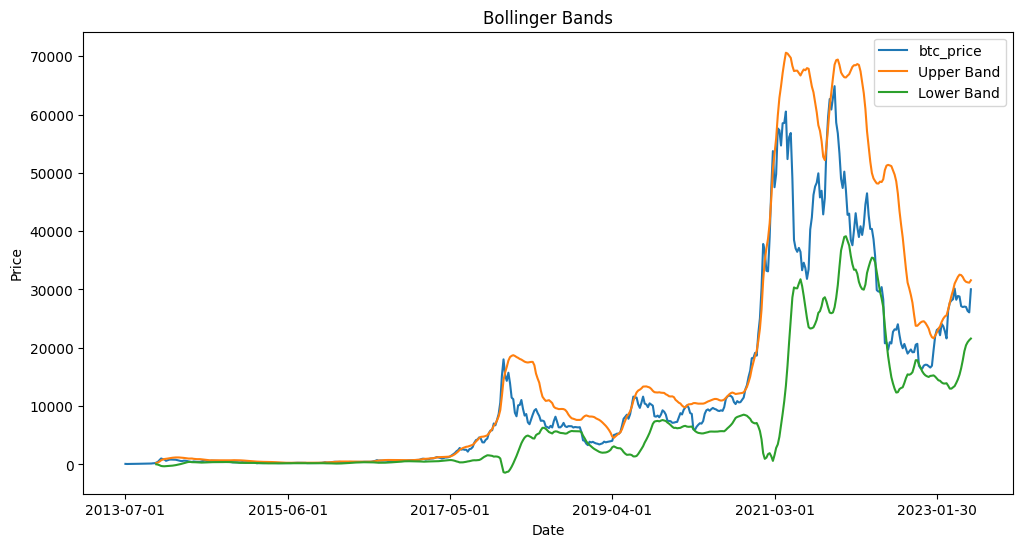

In [27]:
# Calculate SMA
df_data['SMA'] = df_data['btc_price'].rolling(window=14).mean()

# Calculate EMA
df_data['EMA'] = df_data['btc_price'].ewm(span=14, adjust=False).mean()

# Calculate MACD
exp1 = df_data['btc_price'].ewm(span=12, adjust=False).mean()
exp2 = df_data['btc_price'].ewm(span=26, adjust=False).mean()
macd = exp1 - exp2
signal = macd.ewm(span=9, adjust=False).mean()
df_data['MACD'] = macd
df_data['Signal Line'] = signal

# Calculate Bollinger Bands
df_data['SMA_20'] = df_data['btc_price'].rolling(window=20).mean()
df_data['stddev'] = df_data['btc_price'].rolling(window=20).std()
df_data['Lower Band'] = df_data['SMA_20'] - 2*df_data['stddev']
df_data['Upper Band'] = df_data['SMA_20'] + 2*df_data['stddev']

# Calculate RSI
delta = df_data['btc_price'].diff()
up = delta.clip(lower=0)
down = -1*delta.clip(upper=0)
ema_up = up.ewm(com=13, adjust=False).mean()
ema_down = down.ewm(com=13, adjust=False).mean()
rs = ema_up/ema_down
df_data['RSI'] = 100 - (100/(1 + rs))

# Plotting the price along with the Bollinger bands
df_data[['btc_price', 'Upper Band', 'Lower Band']].plot(figsize=(12,6))
plt.title('Bollinger Bands')
plt.ylabel('Price')
plt.show();

In [28]:
df_data.head()

,block_size,market_cap,block_difficulty,hash_ate,btc_price,transaction_count,s&p500,gold,13w_treasury,usd_index,SMA,EMA,MACD,Signal Line,SMA_20,stddev,Lower Band,Upper Band,RSI
Date,,,,,,,,,,,,,,,,,,,
2013-07-01,117436.232199,1.043538e+09,2.003780e+07,162.859886,91.979816,41551.857143,1631.890015,1212.900024,0.035,84.419998,NaN,91.979816,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
2013-07-08,92162.669818,8.523400e+08,2.133533e+07,189.844708,74.932864,35608.714286,1680.189941,1277.800049,0.030,82.989998,NaN,89.706889,-1.359871,-0.271974,NaN,NaN,NaN,NaN,0.000000
2013-07-15,111845.088323,9.985158e+08,2.479419e+07,210.214992,87.532980,40125.428571,1692.089966,1293.300049,0.020,82.580002,NaN,89.417035,-1.404662,-0.498512,NaN,NaN,NaN,NaN,5.379825
2013-07-22,100241.984846,9.969875e+08,2.633047e+07,229.902273,87.176736,37943.000000,1691.650024,1321.699951,0.015,81.620003,NaN,89.118328,-1.452166,-0.689243,NaN,NaN,NaN,NaN,5.371027
2013-07-29,114941.777846,1.031086e+09,3.125696e+07,252.380206,89.926954,39327.571429,1709.670044,1310.599976,0.030,81.910004,NaN,89.226145,-1.253444,-0.802083,NaN,NaN,NaN,NaN,6.640369


# **4. Clean Data**

This section focuses on the process of data cleaning, which involves dealing with issues, including incorrect data, missing information, and unusual values.
- Bad data: we detect and replace incorrect data, such as negative or infinite asset values, with NaN values to maintain the accuracy of the dataset.
- Missing data: we address any gaps in the data by using the ffill (forward fill) and bfill (backward fill) methods to fill in missing values.
- Outliers: we use the z-score technique to identify and appropriately manage any extreme or unusual data points.

In [29]:
def handle_bad_data(df):
    """
    Handle nan/null value from the dataset

    Parameters:
    df (pandas dataframe): The input dataframe.

    Returns:
    A cleaned dataframe with nan replaced by empty.
    """
    df[df <= 0] = np.nan
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.replace('', np.nan, inplace=True)

    return df

def handle_missing_data(prices: pd.DataFrame):
    """
    Handle missing value

    Parameters:
    df (pandas dataframe): The input dataframe.

    Returns:
    A cleaned dataframe with missing value filled using forward fill
    """
    # Forward fill the holes, by filling them with the data behind.
    prices_ffill = prices.fillna(method='ffill', inplace=False)
    prices_filled = prices_ffill.fillna(method='bfill', inplace=False)

    return prices_filled


def detect_outliers_zscore(df, threshold=3):
    """
    Detects and removes outliers from a pandas dataframe using z-score approach.

    Parameters:
    df (pandas dataframe): The input dataframe.
    threshold (float): The z-score threshold above which a data point is considered an outlier. Default is 3.

    Returns:
    A cleaned dataframe with outliers removed.
    """
    z_scores = stats.zscore(df)
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < threshold).all(axis=1)
    cleaned_data = df[filtered_entries]

    return cleaned_data

In [30]:
df_after_bad_data = handle_bad_data(df_data)
df_after_missing_data = handle_missing_data(df_after_bad_data)
data = detect_outliers_zscore(df_after_missing_data)
data.index = pd.to_datetime(data.index)
data['forecast'] = data['btc_price'].shift(-1)
data.head(5)

,block_size,market_cap,block_difficulty,hash_ate,btc_price,transaction_count,s&p500,gold,13w_treasury,usd_index,SMA,EMA,MACD,Signal Line,SMA_20,stddev,Lower Band,Upper Band,RSI,forecast
Date,,,,,,,,,,,,,,,,,,,,
2013-07-01,117436.232199,1.043538e+09,2.003780e+07,162.859886,91.979816,41551.857143,1631.890015,1212.900024,0.035,84.419998,103.786626,91.979816,0.554362,0.067866,128.064813,53.627184,20.810446,235.319181,5.379825,74.932864
2013-07-08,92162.669818,8.523400e+08,2.133533e+07,189.844708,74.932864,35608.714286,1680.189941,1277.800049,0.030,82.989998,103.786626,89.706889,0.554362,0.067866,128.064813,53.627184,20.810446,235.319181,5.379825,87.532980
2013-07-15,111845.088323,9.985158e+08,2.479419e+07,210.214992,87.532980,40125.428571,1692.089966,1293.300049,0.020,82.580002,103.786626,89.417035,0.554362,0.067866,128.064813,53.627184,20.810446,235.319181,5.379825,87.176736
2013-07-22,100241.984846,9.969875e+08,2.633047e+07,229.902273,87.176736,37943.000000,1691.650024,1321.699951,0.015,81.620003,103.786626,89.118328,0.554362,0.067866,128.064813,53.627184,20.810446,235.319181,5.371027,89.926954
2013-07-29,114941.777846,1.031086e+09,3.125696e+07,252.380206,89.926954,39327.571429,1709.670044,1310.599976,0.030,81.910004,103.786626,89.226145,0.554362,0.067866,128.064813,53.627184,20.810446,235.319181,6.640369,96.675121


# **5. Train validation test split**

We split the data into 80:10:10 ratio for training, validation, and testing.

In [31]:
train_data = data[: int(data.shape[0] * 0.80)];
vald_data = data[int(0.80 * data.shape[0]) : int(0.90 * data.shape[0])];
test_data = data[int(0.90* data.shape[0]) : int(data.shape[0])];

# **6. Discretising data using Hidden Markov Models (HMMs)**

Given that our data is non-categorical, unlabeled, and continuous, we convert it into discrete states to use in Belief networks. To achieve this, we will convert our price data into a set of states that correspond to different market conditions, such as bullish, bearish, or stagnant markets. To accomplish this, we will use Hidden Markov Models, which are graphical models specifically designed to identify hidden states within time-series data.

In [ ]:
if not os.path.exists("./hmms"):
    os.makedirs("./hmms")

for series_id in data.columns:
  if series_id == 'forecast':
    break
  else:
    dhmm = hmms.DtHMM.random(3,2)
    data_diff = train_data[series_id].diff()[1:]
    emit_seq = np.array_split(data_diff.apply(lambda x: 1 if x > 0 else 0).values, 32)
    dhmm.baum_welch(emit_seq, 150)
    path = "./hmms/" + series_id.replace(".", "_");
    dhmm.save_params(path)

In [33]:
def discretise_data_with_hmm_and_save_csv(data, data_type):
  if not os.path.exists("./data"):
    os.makedirs("./data")

  disc_test = pd.DataFrame(index = data[1:].index)

  for series_id in data.columns:
    path = "./hmms/" + series_id.replace(".", "_") + ".npz"

    if series_id == 'forecast':
      dhmm = hmms.DtHMM.from_file('./hmms/btc_price.npz')
    else:
      dhmm = hmms.DtHMM.from_file(path)

    data_diff = data[series_id].diff()[1:]
    emit_seq = np.array(data_diff.apply(lambda x: 1 if x > 0 else 0).values)
    with warnings.catch_warnings():
      warnings.filterwarnings("ignore", category=DeprecationWarning)
    (log_prob, s_seq) = dhmm.viterbi(emit_seq)
    disc_test[series_id] = s_seq

  disc_test.to_csv(f'./data/{data_type}.csv')

discretise_data_with_hmm_and_save_csv(train_data, 'train_data')

# **7.Regime switch plot**

In this section, we illustrate the performance of our method for identifying market regimes, by creating a series of color-coded time-series graphs for every asset, showing the regimes we've recognized. These graphs will help us visualize the precision with which we've identified the various market states. By examining the color-coded portions that represent each regime, we can get a better understanding of the effectiveness of our regime detection methodology.

In [34]:
def plot_regime_switch(data, states, data_type):
  if not os.path.exists("./plots"):
    os.makedirs("./plots")

  for series_id in data.columns:
    df = pd.DataFrame(index=data[1:].index)
    df[series_id] = data[series_id][1:]
    df['Diff'] = data[series_id].diff()[1:]
    # index_diff = df.index.difference(states.index)
    df['Regime'] = states[series_id]

    # Get means of all assigned states
    means = df.groupby(['Regime'])['Diff'].mean()
    lst_1 = means.index.tolist()
    lst_2 = means.sort_values().index.tolist()
    map_regimes = dict(zip(lst_2, lst_1))
    df['Regime'] = df['Regime'].map(map_regimes)

    cmap = ListedColormap(['r','b','g'],'indexed')
    norm = BoundaryNorm(range(3 + 1), cmap.N)
    inxval = mdates.date2num(df[series_id].index)
    points = np.array([inxval, df[series_id]]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(df['Regime'])
    plt.gca().add_collection(lc)
    plt.xlim(df[series_id].index.min(), df[series_id].index.max())
    plt.ylim(df[series_id].min(), df[series_id].max())
    r_patch = mpatches.Patch(color='red', label='Bear')
    g_patch = mpatches.Patch(color='green', label='Bull')
    b_patch = mpatches.Patch(color='blue', label='Stagnant')
    plt.legend(handles=[r_patch, g_patch, b_patch])
    name = f"./plots/{series_id.replace('.', '_')}_{'TRAIN'}.png"
    plt.savefig(name)
    plt.close()


states = pd.read_csv("./data/train_data.csv", index_col=0)
states.index = pd.to_datetime(states.index)
# Remove first row of train_data
plot_regime_switch(train_data, states, 'TRAIN')

# **8. Learning Bayesian and Markov Network using Hill Climbing**

We initially use Hill Climb Search method to learn our Bayesian Network and Markov network and make a comparison of each model on the validation set. We do not optimize the model at this stage of our project.

In [43]:
# Retrieve training set
train_data = pd.read_csv("./data/train_data.csv", index_col=0);
# Initialise Hill Climbing Estimator
hc = HillClimbSearch(train_data)

While building the model, we will assess the algorithm's efficacy under a variety of scoring techniques. These include the Bayesian Information Criterion (BIC), Bayesian Dirichlet Equivalent Uniform (BDEU), Bayesian Dirichlet Score (BDS), and K2. We will illustrate the connections that are created using each of these methods. The main objective of implementing these diverse scoring methods is to examine and contrast the algorithm's performance under each of these criteria. This comparison will offer valuable insights into the scoring method that would be most effective for our analysis.


In [44]:
K2_model = hc.estimate(scoring_method=K2Score(train_data), max_iter=4)
sorted(K2_model.nodes())
K2_model.edges()

  0%|          | 0/4 [00:00<?, ?it/s]

OutEdgeView([('btc_price', 'RSI'), ('EMA', 'MACD'), ('SMA_20', 'Upper Band'), ('forecast', 'btc_price')])

In [45]:
Bdeu_model = hc.estimate(scoring_method=BDeuScore(train_data), max_iter=5)
sorted(Bdeu_model.nodes())
Bdeu_model.edges()

  0%|          | 0/5 [00:00<?, ?it/s]

OutEdgeView([('btc_price', 'RSI'), ('btc_price', 'forecast'), ('EMA', 'MACD'), ('Upper Band', 'SMA_20'), ('Upper Band', 'stddev')])

In [46]:
Bic_model = hc.estimate(scoring_method=BicScore(train_data), max_iter=5)
sorted(Bic_model.nodes())
Bic_model.edges()

  0%|          | 0/5 [00:00<?, ?it/s]

OutEdgeView([('btc_price', 'RSI'), ('btc_price', 'forecast'), ('MACD', 'EMA'), ('stddev', 'Upper Band'), ('Upper Band', 'SMA_20')])

In [47]:
BDs_model = hc.estimate(scoring_method=BDsScore(train_data), max_iter=15)
sorted(BDs_model.nodes())
BDs_model.edges()

  0%|          | 0/15 [00:00<?, ?it/s]

OutEdgeView([('btc_price', 'RSI'), ('btc_price', 'forecast'), ('13w_treasury', 'hash_ate'), ('SMA', 'EMA'), ('EMA', 'MACD'), ('EMA', 'btc_price'), ('Signal Line', 'SMA'), ('SMA_20', 'SMA'), ('stddev', 'MACD'), ('Lower Band', 'stddev'), ('Lower Band', 'SMA_20'), ('Upper Band', 'SMA_20'), ('Upper Band', 'stddev'), ('Upper Band', 'Signal Line'), ('RSI', 'market_cap')])

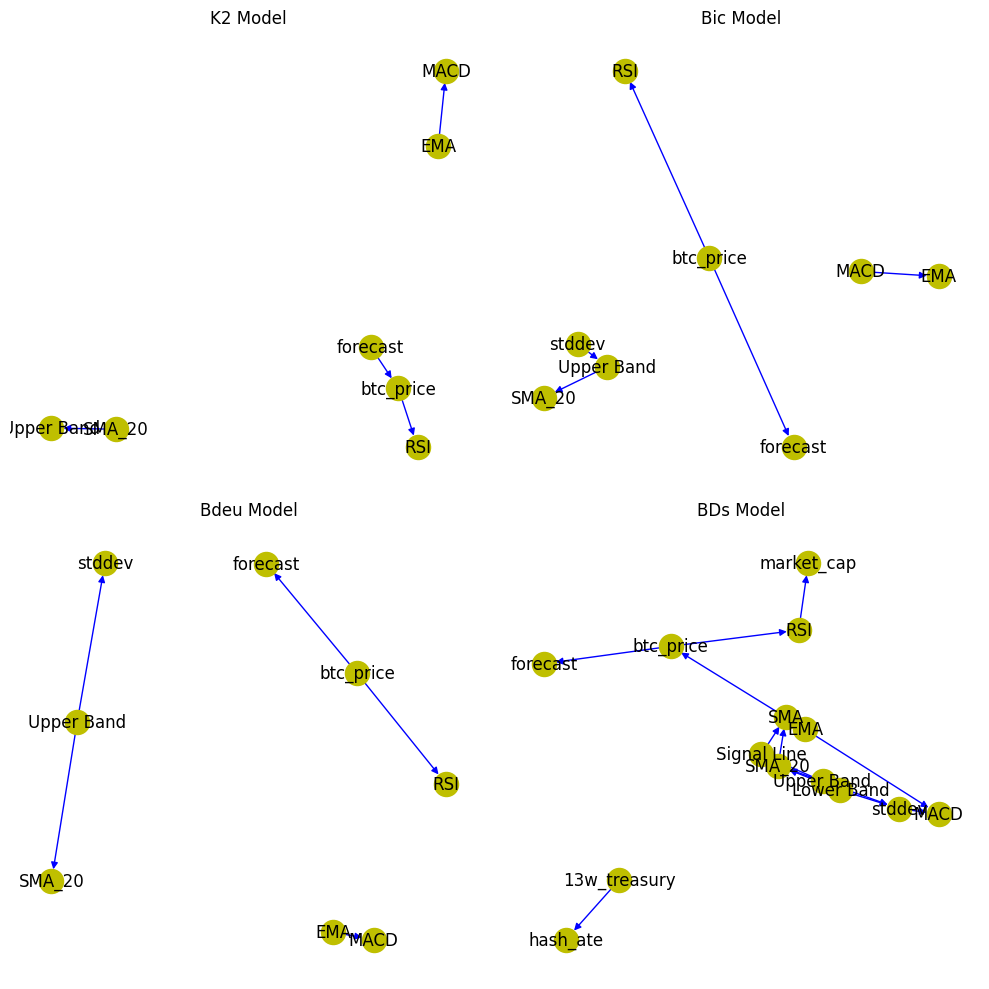

In [48]:
# Create subplots
# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot K2_model
G1 = nx.DiGraph()
G1.add_edges_from(K2_model.edges())
pos1 = nx.spring_layout(G1, iterations=10)
nx.draw(G1, node_color='y', with_labels=True, edge_color='b', font_weight=0.5, ax=axs[0, 0])
axs[0, 0].set_title('K2 Model')

# Plot Bic_model
G2 = nx.DiGraph()
G2.add_edges_from(Bic_model.edges())
pos2 = nx.spring_layout(G2, iterations=10)
nx.draw(G2, node_color='y', with_labels=True, edge_color='b', font_weight=0.5, ax=axs[0, 1])
axs[0, 1].set_title('Bic Model')

# Plot Bdeu_model
G3 = nx.DiGraph()
G3.add_edges_from(Bdeu_model.edges())
pos3 = nx.spring_layout(G3, iterations=10)
nx.draw(G3, node_color='y', with_labels=True, edge_color='b', font_weight=0.5, ax=axs[1, 0])
axs[1, 0].set_title('Bdeu Model')

# Plot BDs_model
G4 = nx.DiGraph()
G4.add_edges_from(BDs_model.edges())
pos4 = nx.spring_layout(G4, iterations=10)
nx.draw(G4, node_color='y', with_labels=True, edge_color='b', font_weight=0.5, ax=axs[1, 1])
axs[1, 1].set_title('BDs Model')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [49]:
# Bayesian Network
model_k2_bayesian = BayesianNetwork(ebunch=K2_model.edges())
model_k2_bayesian.fit(train_data)

model_bdeu_bayesian = BayesianNetwork(ebunch=Bdeu_model.edges())
model_bdeu_bayesian.fit(train_data)

model_bds_bayesian = BayesianNetwork(ebunch=BDs_model.edges())
model_bds_bayesian.fit(train_data)

model_bic_bayesian = BayesianNetwork(ebunch=Bic_model.edges())
model_bic_bayesian.fit(train_data)

print('model_k2 nodes: \n', model_k2_bayesian.nodes())
print('model_bdeu nodes: \n', model_bdeu_bayesian.nodes())
print('model_bds nodes: \n', model_bds_bayesian.nodes())
print('model_bic nodes: \n', model_bic_bayesian.nodes())

model_k2 nodes: 
 ['btc_price', 'RSI', 'EMA', 'MACD', 'SMA_20', 'Upper Band', 'forecast']
model_bdeu nodes: 
 ['btc_price', 'RSI', 'forecast', 'EMA', 'MACD', 'Upper Band', 'SMA_20', 'stddev']
model_bds nodes: 
 ['btc_price', 'RSI', 'forecast', '13w_treasury', 'hash_ate', 'SMA', 'EMA', 'MACD', 'Signal Line', 'SMA_20', 'stddev', 'Lower Band', 'Upper Band', 'market_cap']
model_bic nodes: 
 ['btc_price', 'RSI', 'forecast', 'MACD', 'EMA', 'stddev', 'Upper Band', 'SMA_20']


In [51]:
## Discretise the validation dataset and plot
discretise_data_with_hmm_and_save_csv(vald_data,'validation_data')
states = pd.read_csv("./data/validation_data.csv", index_col=0)
states.index = pd.to_datetime(states.index)
plot_regime_switch(vald_data, states, 'VALIDATION')

In [52]:
def predict_value(model_struct, scoring_method, states):

    column_names_df1 = set(model_struct.nodes())
    column_names_df2 = set(states.columns)
    columns_only_in_df2 = column_names_df2 - column_names_df1

    print(columns_only_in_df2)
    print(column_names_df2)
    print(len(column_names_df1))
    print(len(column_names_df2))
    print(len(columns_only_in_df2))

    data_new = states.drop(columns=list(columns_only_in_df2) + ['forecast'], axis=1)
    print(data_new.shape)
    print(data_new.columns)
    prediction = model_struct.predict(data_new)
    pred_value = prediction['forecast'].to_numpy()
    return pred_value

pred_value_vald_k2_bayesian = predict_value(model_k2_bayesian, 'k2', states)
#pred_value_vald_k2_markov = predict_value(model_k2_bayesian, 'k2', states)

{'hash_ate', 'gold', 'block_difficulty', 'transaction_count', 'block_size', 'stddev', 'market_cap', 'Signal Line', 'usd_index', '13w_treasury', 'SMA', 's&p500', 'Lower Band'}
{'EMA', 'gold', 'block_size', 'Signal Line', 'Upper Band', 'MACD', 'btc_price', 'forecast', 's&p500', 'RSI', 'usd_index', '13w_treasury', 'SMA', 'SMA_20', 'hash_ate', 'block_difficulty', 'transaction_count', 'stddev', 'market_cap', 'Lower Band'}
7
20
13
(47, 6)
Index(['btc_price', 'EMA', 'MACD', 'SMA_20', 'Upper Band', 'RSI'], dtype='object')


  0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
# pred_value_vald_bdeu_bayesian = predict_value(model_bdeu_bayesian, 'bdeu', states)
# pred_value_vald_bds_bayesian = predict_value(model_bds_bayesian, 'bds', states)
# pred_value_vald_bic_bayesian = predict_value(model_bic_bayesian, 'bic', states)

In [60]:
# Record real data observation, to be compared with the predicted one
vald_real = states['btc_price'].to_numpy()

print("\nReal Value: ")
print(vald_real);

def calculate_error(pred_value, scoring_method, real):
  print(f'\nPredicted Value {scoring_method}: ')
  print(pred_value)

  error = np.mean(real != np.roll(pred_value, 1))

  print(f'\nError {scoring_method}: ')
  print(error * 100)
  return error

error_vald_k2_bayesian = calculate_error(pred_value_vald_k2_bayesian, 'k2',vald_real)


Real Value: 
[1 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0
 0 0 0 0 0 2 2 2 0 0]

Predicted Value k2: 
[1 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0
 0 0 0 0 0 2 2 2 0 0]

Error k2: 
14.893617021276595


Upon conducting our initial evaluation, our Probabilistic Graphical Model (PGM) exhibited a significant error rate of 47% on the validation dataset. This was primarily due to the limited predictive power of our model, as our directed graph plot revealed that only two variables, namely Bitcoin (BTC) price and Market Capitalization, were able to predict the BTC price effectively. Other variables failed to establish a substantial connection for price prediction, indicating that our PGM's learned structure needed augmentation.

Recognizing the need for model refinement, we introduced additional technical indicators into our graph model. By incorporating variables such as Moving Average Convergence Divergence (MACD), Simple Moving Average_20 (SMA_20), standard deviation, Relative Strength Index (RSI), and Bollinger Bands, we aimed to enhance the predictive power of our model.

The addition of these indicators has yielded encouraging results. We've managed to reduce the error rate significantly to 14.89%, marking a substantial improvement in our model's performance. This suggests that the inclusion of these technical indicators has effectively harnessed the latent predictive potential within our data, considerably enhancing the accuracy of our forecasts.

Looking forward, we will continue to explore other potential enhancements to our model. This includes the incorporation of additional predictive features. We also plan to experiment with other structure learning approaches such as PC and Exhaustive Search, or a hybrid of constraint and score-based learning. Additionally, we aim to utilize different techniques for parameter learning.

We anticipate that these ongoing enhancements will continue to optimize both the structure and predictive power of our model, resulting in even more accurate predictions in future iterations.